In [1]:
from math import floor

import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from matplotlib import pyplot as plt

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
print(len(dataset), len(dataset)*BATCH_SIZE)

68 2176


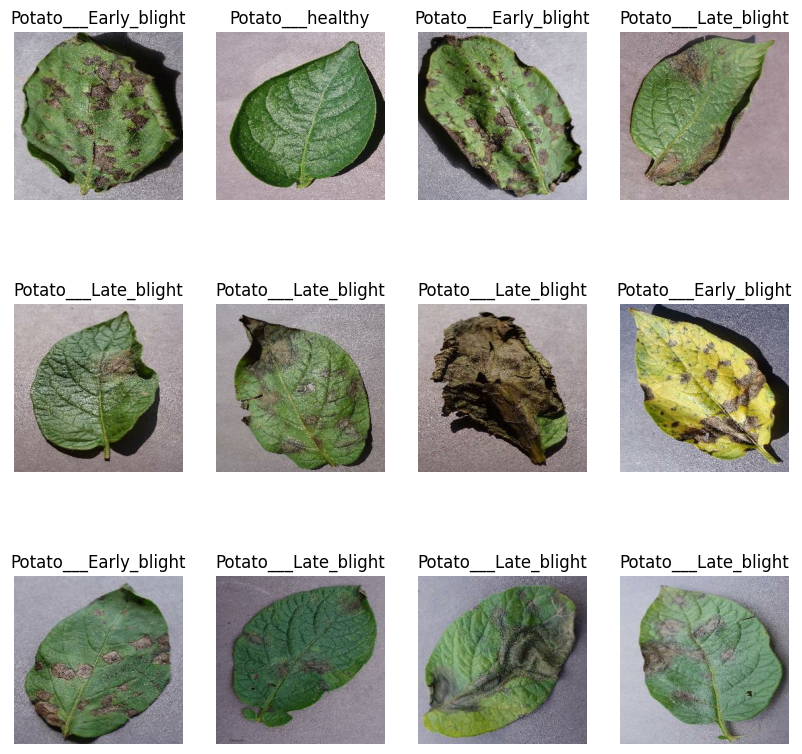

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [10]:
def train_val_test_split(dataset: tf.data.Dataset,
                         train_split = 0.8,
                         val_split = 0.1,
                         test_split = 0.1,
                         shuffle = True,
                         shuffle_size = 10000,
                         random_seed = 12
                        ):
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed = random_seed)
        
    train_size = floor(train_split*len(dataset))
    val_size = floor(val_split*len(dataset))
    
    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size)
    val_dataset = test_dataset.take(val_size)
    test_dataset = test_dataset.skip(val_size)
    
    return train_dataset, val_dataset, test_dataset

In [11]:
train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)
print(len(train_dataset), len(val_dataset), len(test_dataset))

54 6 8


In [12]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
train_dataset = train_dataset.map(
                    lambda x, y: (data_augmentation_layer(x, training=True), y) 
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale_layer,
    # data_augmentation_layer,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
path = '../tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = path,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = 'max',
    save_freq = 'epoch',
    options = None,
    initial_value_threshold=None,
)

In [19]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=50,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 0.8832 - accuracy: 0.4838
Epoch 1: val_accuracy improved from -inf to 0.65104, saving model to tmp\checkpoint
54/54 [==============================] - 26s 150ms/step - loss: 0.8832 - accuracy: 0.4838 - val_loss: 0.8269 - val_accuracy: 0.6510
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.5541 - accuracy: 0.7506
Epoch 2: val_accuracy improved from 0.65104 to 0.82812, saving model to tmp\checkpoint
54/54 [==============================] - 7s 125ms/step - loss: 0.5541 - accuracy: 0.7506 - val_loss: 0.3891 - val_accuracy: 0.8281
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.3260 - accuracy: 0.8669
Epoch 3: val_accuracy improved from 0.82812 to 0.85417, saving model to tmp\checkpoint
54/54 [==============================] - 7s 127ms/step - loss: 0.3260 - accuracy: 0.8669 - val_loss: 0.3743 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - ETA: 0s - loss

In [66]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 0s 37ms/step - loss: 0.1079 - accuracy: 0.9492


In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

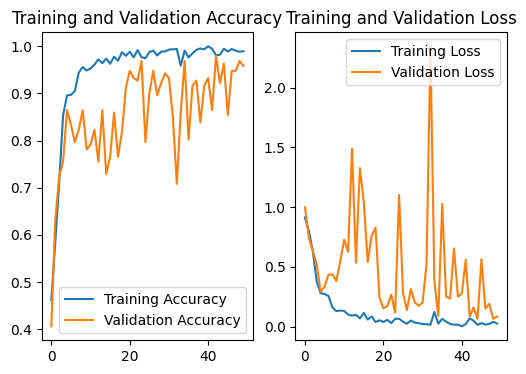

In [68]:
plt.figure(figsize=(6, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [52]:
model.save_weights('./saved_models/baseline_99acc')

In [21]:
model.load_weights('../saved_models/baseline_99acc')

In [22]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 9s 21ms/step - loss: 0.0456 - accuracy: 0.9766


In [ ]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}")

In [ ]:
# model.save("../potatoes.h5")